In [1]:
import os
import time
import pickle
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import seaborn as sns
from scipy import interpolate
from datetime import datetime
import pandas as pd
from tool import EarlyStopping
from sklearn.metrics import roc_auc_score,mean_squared_error,mean_absolute_error, r2_score
from common import *
from net import CRNN

import torch
import torch.nn.functional as F
import torch.optim as optim

from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, Sampler, TensorDataset
from torch.utils.data.sampler import RandomSampler
    
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

# 1-Data preparation

In [2]:
n_cyc = 30
in_stride = 3
fea_num = 100

v_low = 3.36
v_upp = 3.60
q_low = 610
q_upp = 1190
rul_factor = 3000
cap_factor = 1190

In [3]:
pkl_list = os.listdir('./data/our_data/')
pkl_list = sorted(pkl_list, key=lambda x:int(x.split('-')[0])*10 + int(x[-5]))

train_name = []
for name in pkl_list:
    train_name.append(name[:-4])

In [4]:
all_loader = dict()
print('----init_train----')
for name in train_name:
    tmp_fea, tmp_lbl = get_xy(name, n_cyc, in_stride, fea_num, v_low, v_upp, q_low, q_upp, rul_factor, cap_factor)
    all_loader.update({name:{'fea':tmp_fea,'lbl':tmp_lbl}})

----init_train----
1-1 length is 1466 v_max: 0.9583 q_max: 0.9047 dv_max: 0.1396 dq_max: 0.0001
1-2 length is 2640 v_max: 0.9633 q_max: 0.9439 dv_max: 0.1342 dq_max: 0.0023
1-3 length is 1820 v_max: 0.9325 q_max: 0.9233 dv_max: 0.0730 dq_max: 0.0053
1-4 length is 1462 v_max: 0.9233 q_max: 0.9234 dv_max: 0.0802 dq_max: 0.0052
1-5 length is 1933 v_max: 0.9271 q_max: 0.9128 dv_max: 0.0013 dq_max: 0.0079
1-6 length is 1105 v_max: 0.9596 q_max: 0.9022 dv_max: 0.0755 dq_max: 0.0000
1-7 length is 1640 v_max: 0.9558 q_max: 0.9232 dv_max: 0.1589 dq_max: 0.0000
1-8 length is 2247 v_max: 0.9571 q_max: 0.9337 dv_max: 0.1714 dq_max: 0.0000
2-2 length is 2613 v_max: 0.9492 q_max: 0.9726 dv_max: 0.1172 dq_max: 0.0024
2-3 length is 1713 v_max: 0.9363 q_max: 0.9285 dv_max: 0.1237 dq_max: 0.0079
2-4 length is 1461 v_max: 0.9517 q_max: 0.9206 dv_max: 0.1456 dq_max: 0.0000
2-5 length is 1348 v_max: 0.9300 q_max: 0.9149 dv_max: 0.0301 dq_max: 0.0079
2-6 length is 1534 v_max: 0.9208 q_max: 0.9439 dv_max: 0.

# 2-Dataloader generation

In [5]:
new_valid = ['4-3', '5-7', '3-3', '2-3', '9-3', '10-5', '3-2', '3-7']
new_train = ['9-1', '2-2', '4-7','9-7', '1-8','4-6','2-7','8-4', '7-2','10-3', '2-4', '7-4', '3-4',
            '5-4', '8-7','7-7', '4-4','1-3', '7-1','5-2', '6-4', '9-8','9-5','6-3','10-8','1-6','3-5',
             '2-6', '3-8', '3-6', '4-8', '7-8','5-1', '2-8', '8-2','1-5','7-3', '10-2','5-5', '9-2','5-6', '1-7', 
             '8-3', '4-1','4-2','1-4','6-5', ]
new_test  = ['9-6','4-5','1-2', '10-7','1-1', '6-1','6-6', '9-4','10-4','8-5', '5-3','10-6',
            '2-5','6-2','3-1','8-8', '8-1','8-6','7-6','6-8','7-5','10-1']

In [6]:
stride = 10
train_fea, train_lbl = [], []
for name in new_train + new_valid:
    tmp_fea, tmp_lbl = all_loader[name]['fea'],all_loader[name]['lbl']
    train_fea.append(tmp_fea[::stride])
    train_lbl.append(tmp_lbl[::stride])
train_fea = np.vstack(train_fea)
train_lbl = np.vstack(train_lbl).squeeze()

stride = 10
valid_fea, valid_lbl = [], []
for name in new_test:
    tmp_fea, tmp_lbl = all_loader[name]['fea'],all_loader[name]['lbl']
    valid_fea.append(tmp_fea[::stride])
    valid_lbl.append(tmp_lbl[::stride])
valid_fea = np.vstack(valid_fea)
valid_lbl = np.vstack(valid_lbl).squeeze()

print(train_fea.shape, train_lbl.shape, valid_fea.shape, valid_lbl.shape)

(10279, 10, 100, 4) (10279, 11) (4074, 10, 100, 4) (4074, 11)


In [7]:
seed_torch(0)
batch_size = 256

train_fea_ = train_fea[:].copy()
train_lbl_ = train_lbl[:].copy()

train_fea_ = train_fea_.transpose(0,3,2,1)
valid_fea_ = valid_fea.transpose(0,3,2,1)

trainset = TensorDataset(torch.Tensor(train_fea_), torch.Tensor(train_lbl_))
validset = TensorDataset(torch.Tensor(valid_fea_), torch.Tensor(valid_lbl))

train_loader = DataLoader(trainset, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(validset, batch_size=batch_size,)

train_loader_t = DataLoader(trainset, batch_size=batch_size,shuffle=False)

# 3-Model pre-training

 The pretrained model is saved in './model/wx_inner/wx_inner_pretrain_end.pt'
 
 If loading this model, readers can skip step 3 and run step 4 directly.

In [8]:
'''
lamda (float): The weight of RUL loss
alpha (List: [float]): The weights of Capacity loss
'''         
lamda = 1e-2
alpha = torch.Tensor([0.1] * 10 )

In [9]:
'''
model training 
'''
tic = time.time()
seed_torch(2022)
device = 'cuda'
model = CRNN(100,4,64,64)
model = model.to(device)

num_epochs = 10000


model_load = False
trainer = Trainer(lr = 8e-4, n_epochs = num_epochs,device = device, patience = 1200,
                  lamda = lamda, alpha = alpha, model_name='./model/wx_inner/wx_inner_pretrain')
model ,train_loss, valid_loss, total_loss = trainer.train(train_loader, valid_loader, model, model_load)

print(time.time()-tic)

Epoch number :  100
-- "train" loss 0.01419 -- "valid" loss 0.01617 -- "total" loss 0.0001569
Epoch number :  200
-- "train" loss 0.007333 -- "valid" loss 0.009662 -- "total" loss 9.314e-05
Epoch number :  300
-- "train" loss 0.006686 -- "valid" loss 0.009141 -- "total" loss 7.463e-05
Epoch number :  400
-- "train" loss 0.006628 -- "valid" loss 0.008995 -- "total" loss 7.927e-05
Epoch number :  500
-- "train" loss 0.006459 -- "valid" loss 0.008986 -- "total" loss 7.334e-05
Epoch number :  600
-- "train" loss 0.006317 -- "valid" loss 0.008893 -- "total" loss 7.227e-05
Epoch number :  700
-- "train" loss 0.006146 -- "valid" loss 0.008596 -- "total" loss 7.016e-05
Epoch number :  800
-- "train" loss 0.00597 -- "valid" loss 0.00878 -- "total" loss 7.141e-05
Epoch number :  900
-- "train" loss 0.005728 -- "valid" loss 0.008166 -- "total" loss 6.769e-05
Epoch number :  1000
-- "train" loss 0.005408 -- "valid" loss 0.008337 -- "total" loss 6.856e-05
Epoch number :  1100
-- "train" loss 0.0049

# 4-Online transfer

In [10]:
lamda = 0.0
train_weight9 = [0., 0.1, 0., 0., 0.1, 0., 0., 0., 0.,]
valid_weight9 = [0. if (i!=0) else 0.1 for i in train_weight9]
train_alpha = torch.Tensor(train_weight9 + [0.] )
valid_alpha = torch.Tensor(valid_weight9 + [0.])

pretrain_model_path = './model/wx_inner/wx_inner_pretrain_end.pt'
finetune_model_path = './model/wx_inner/wx_inner_finetune'

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


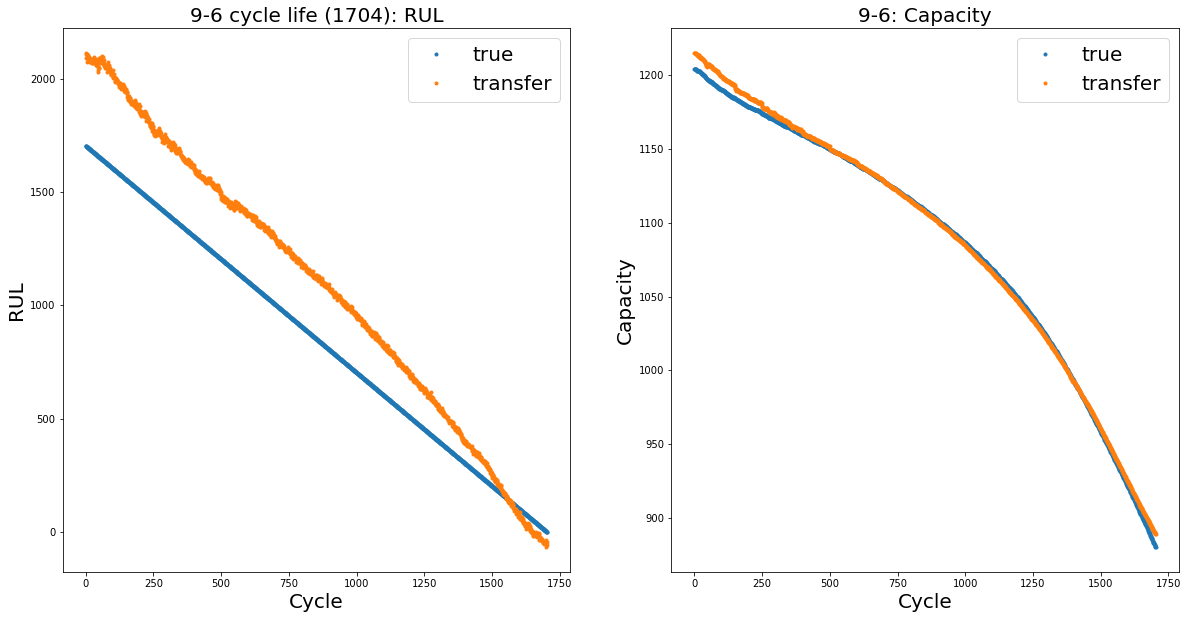

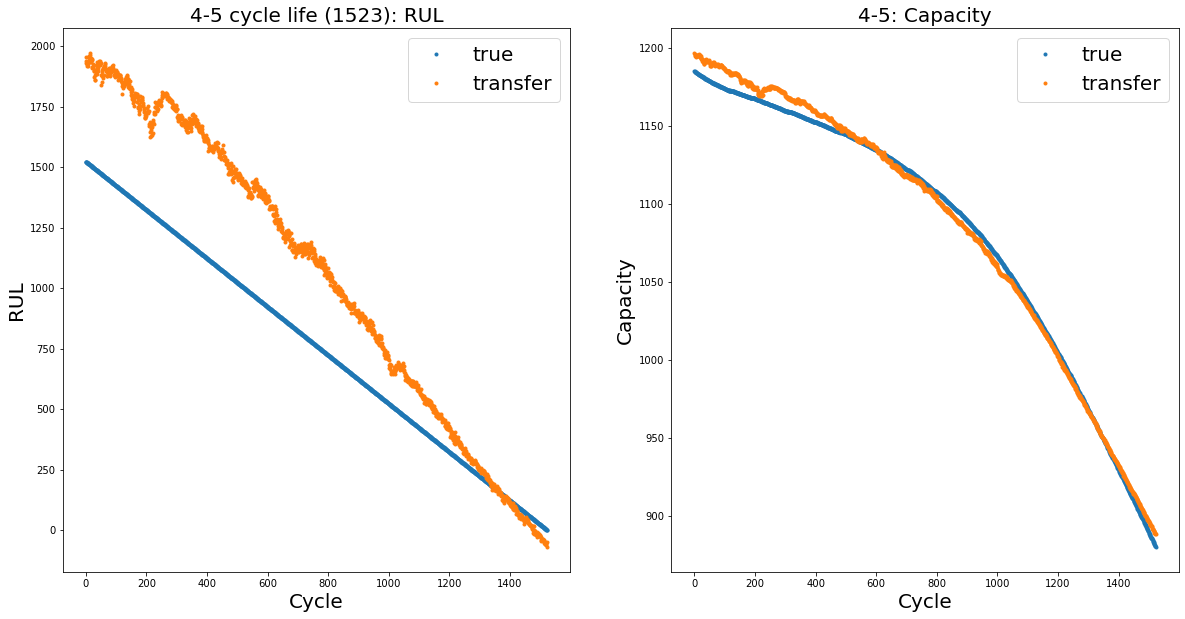

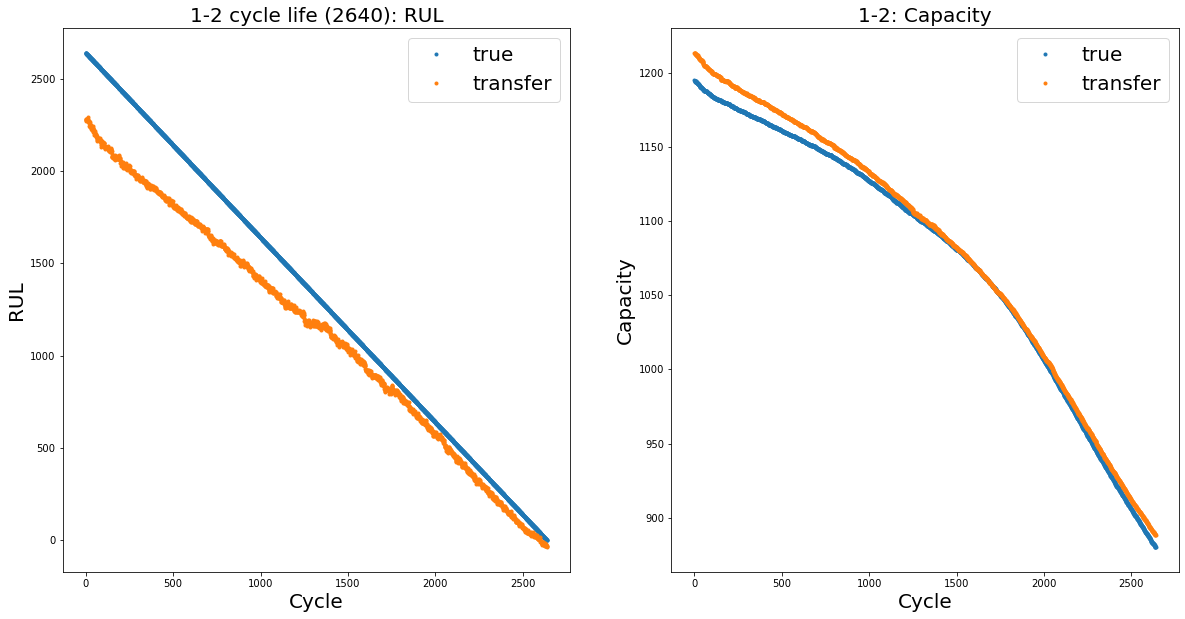

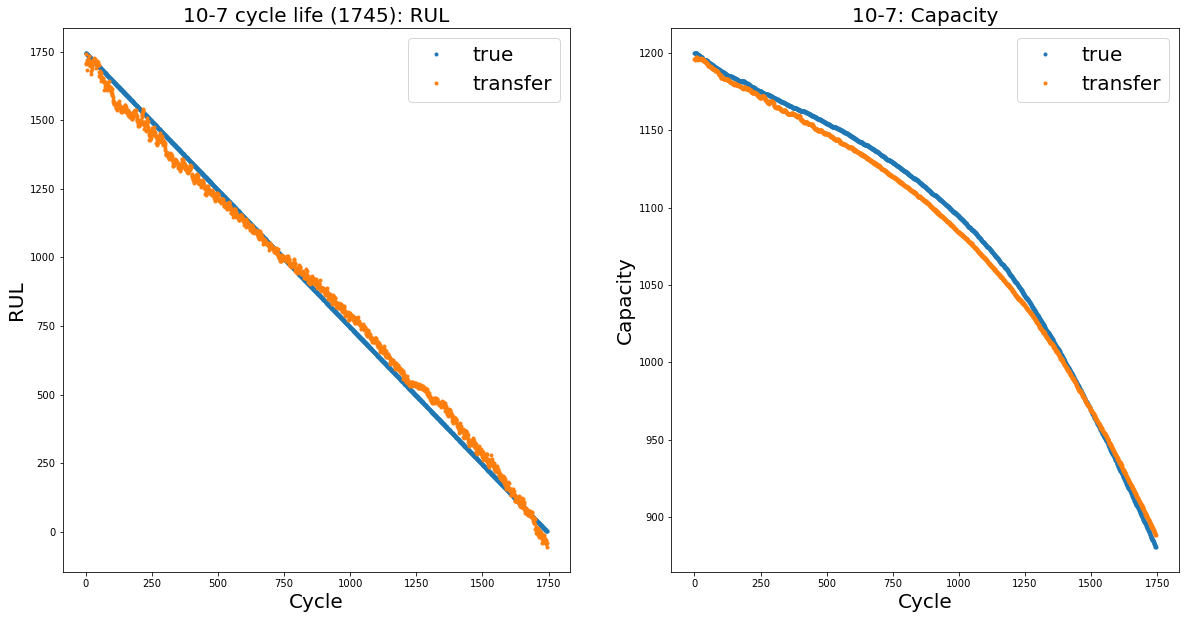

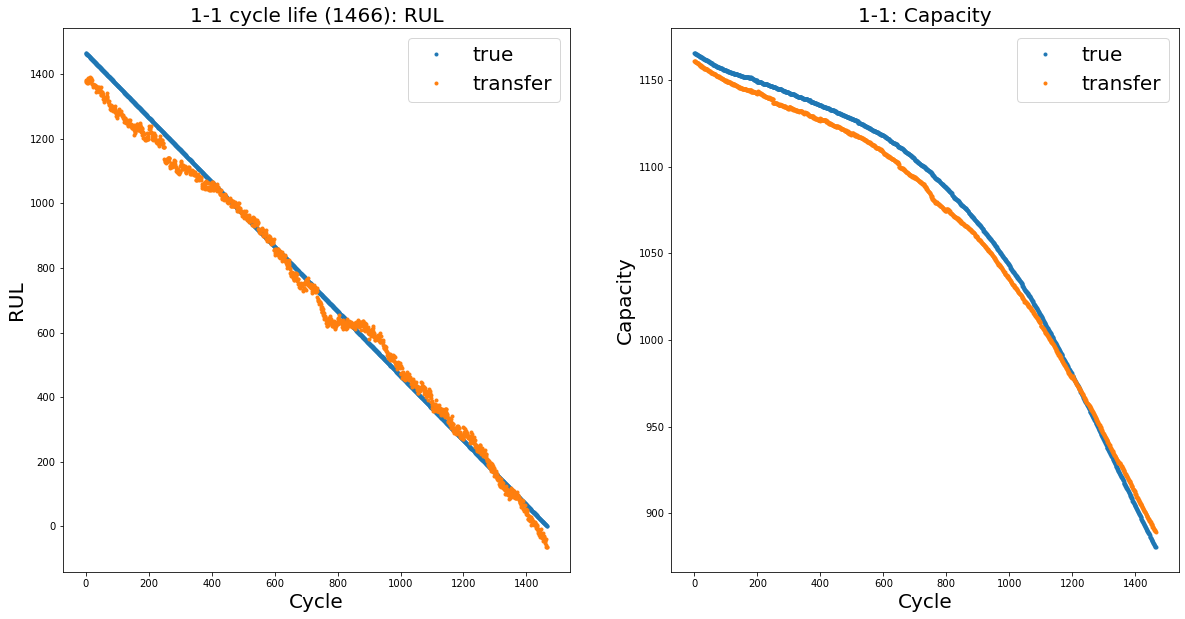

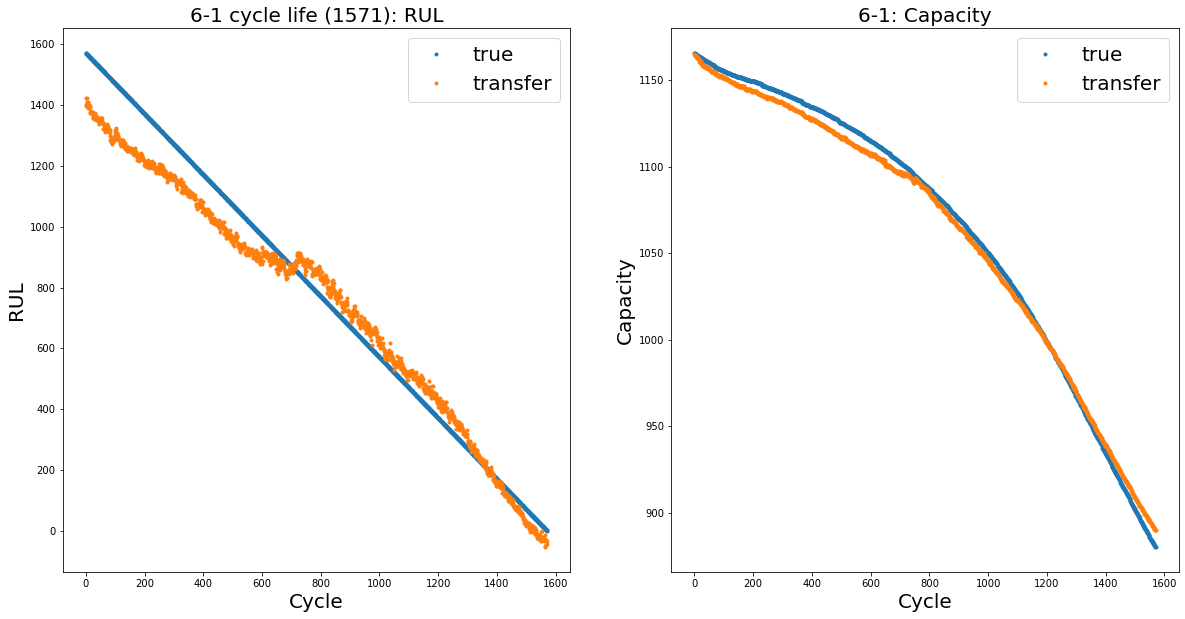

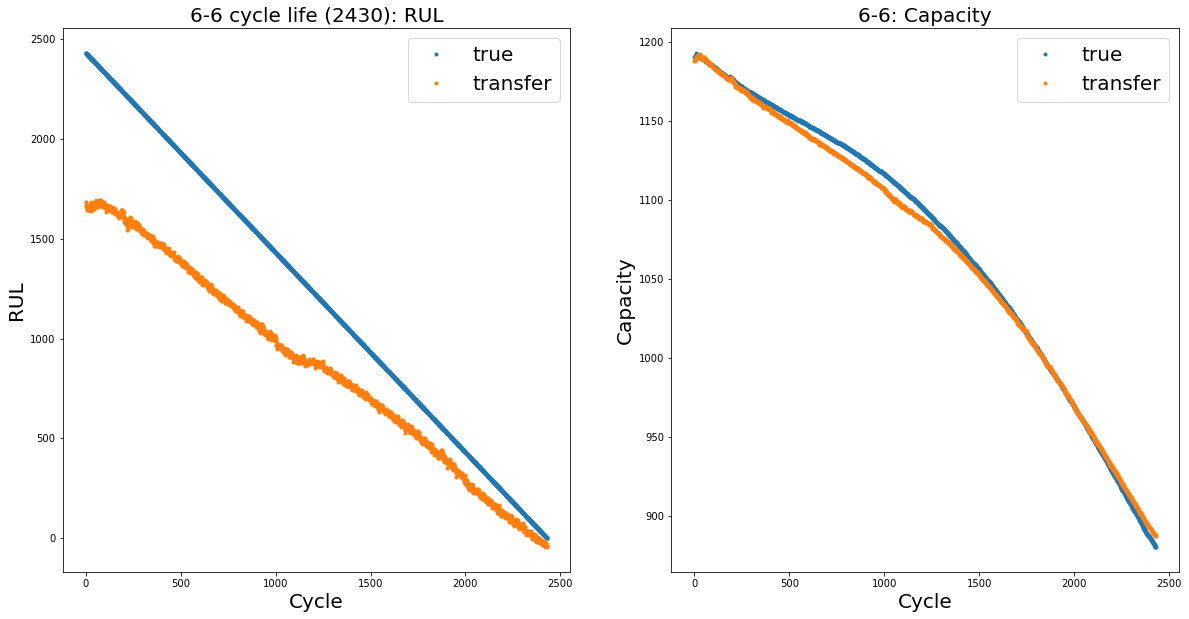

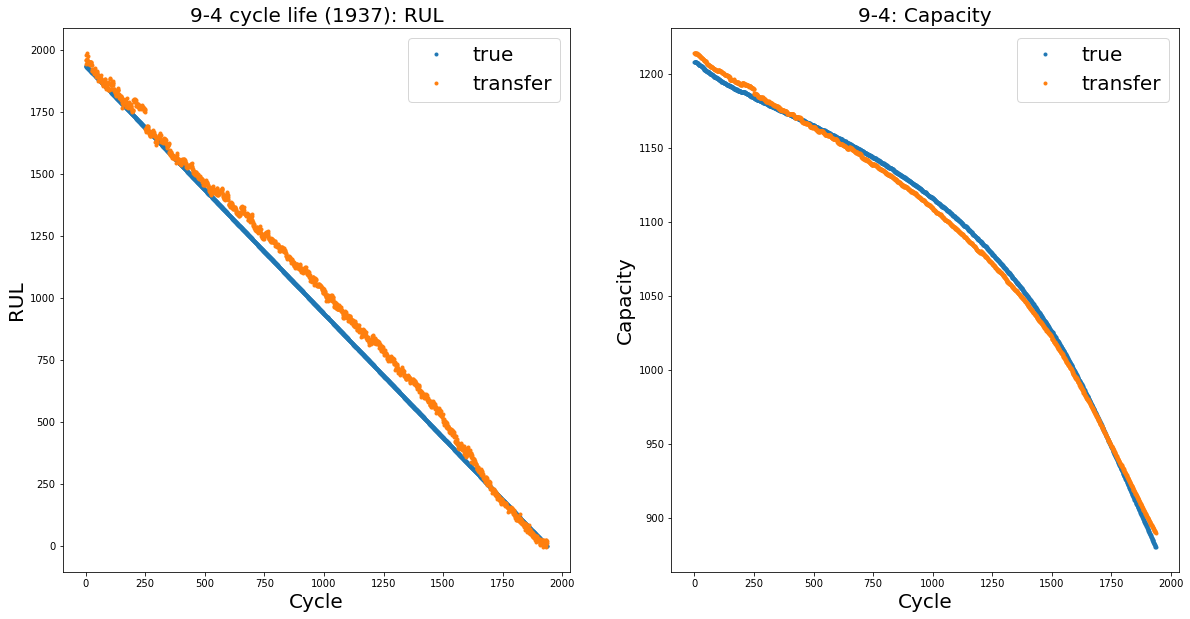

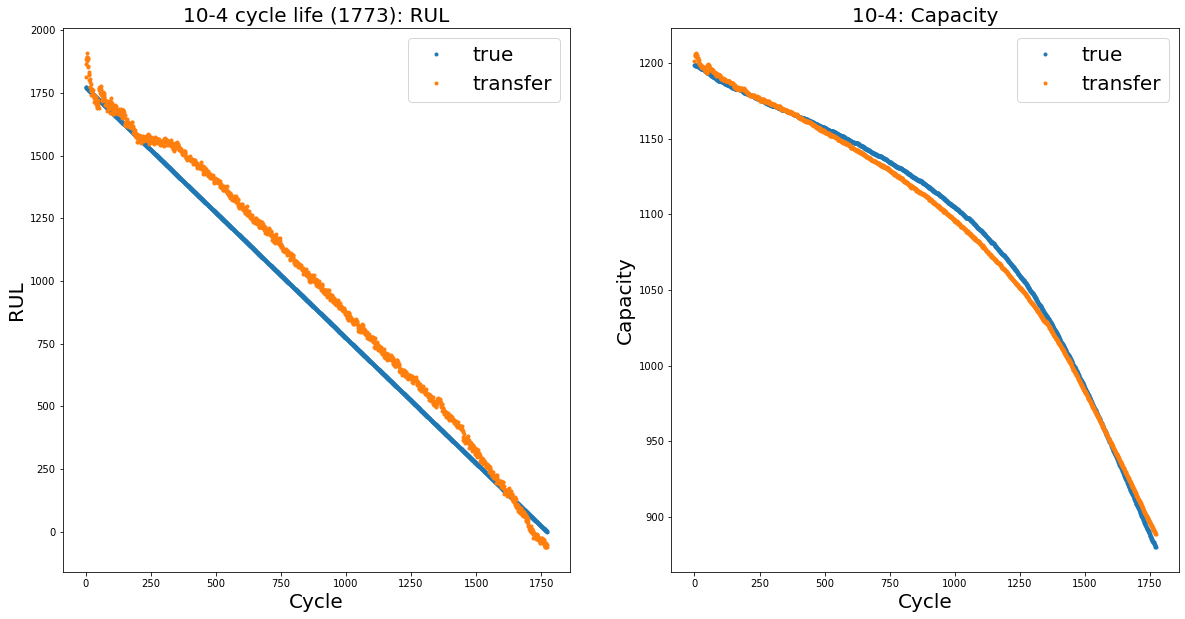

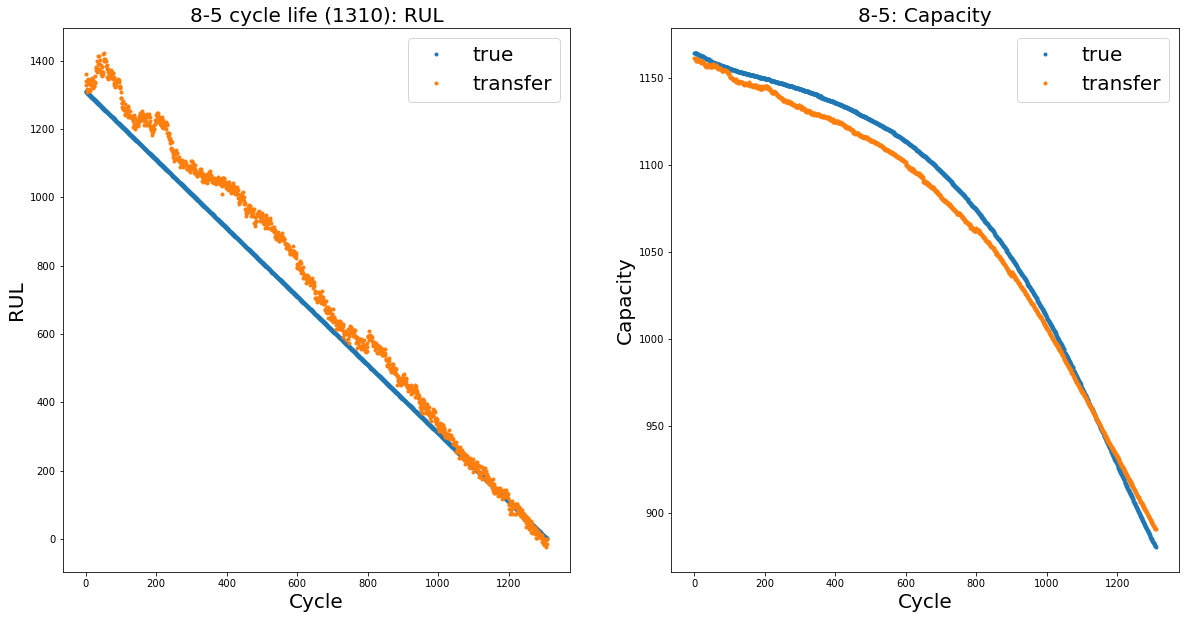

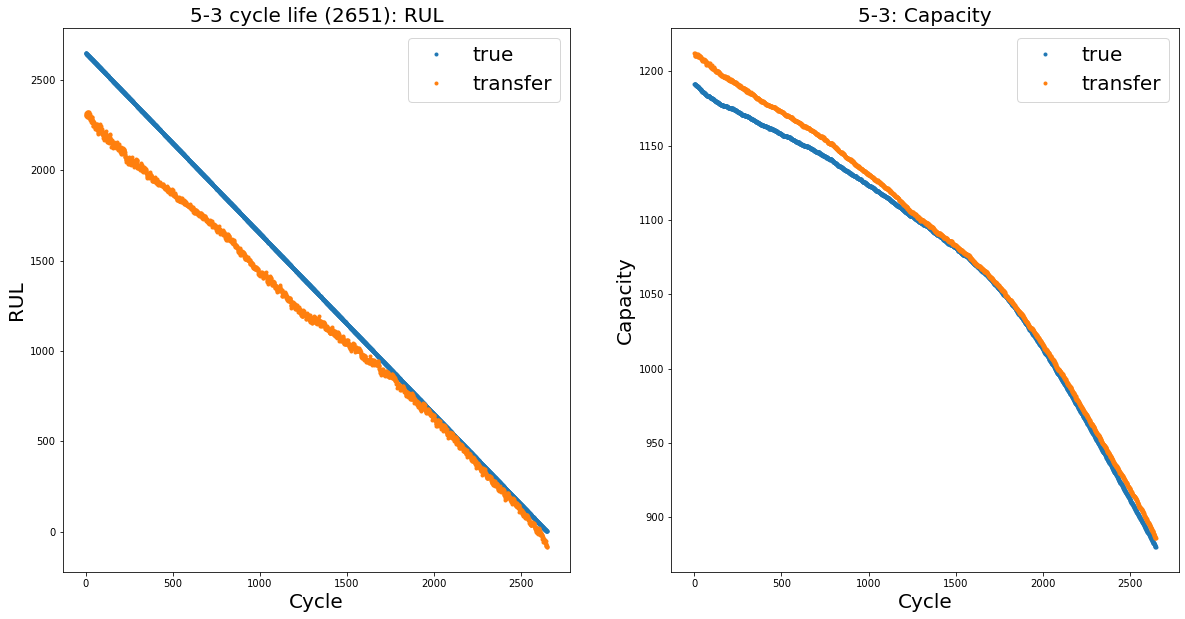

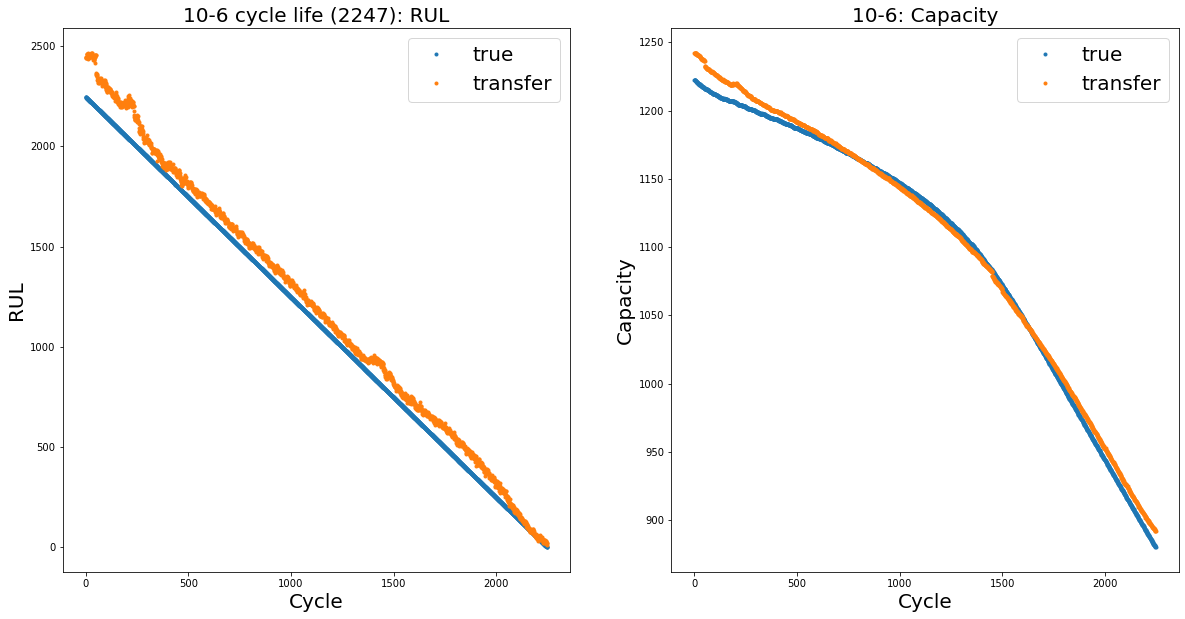

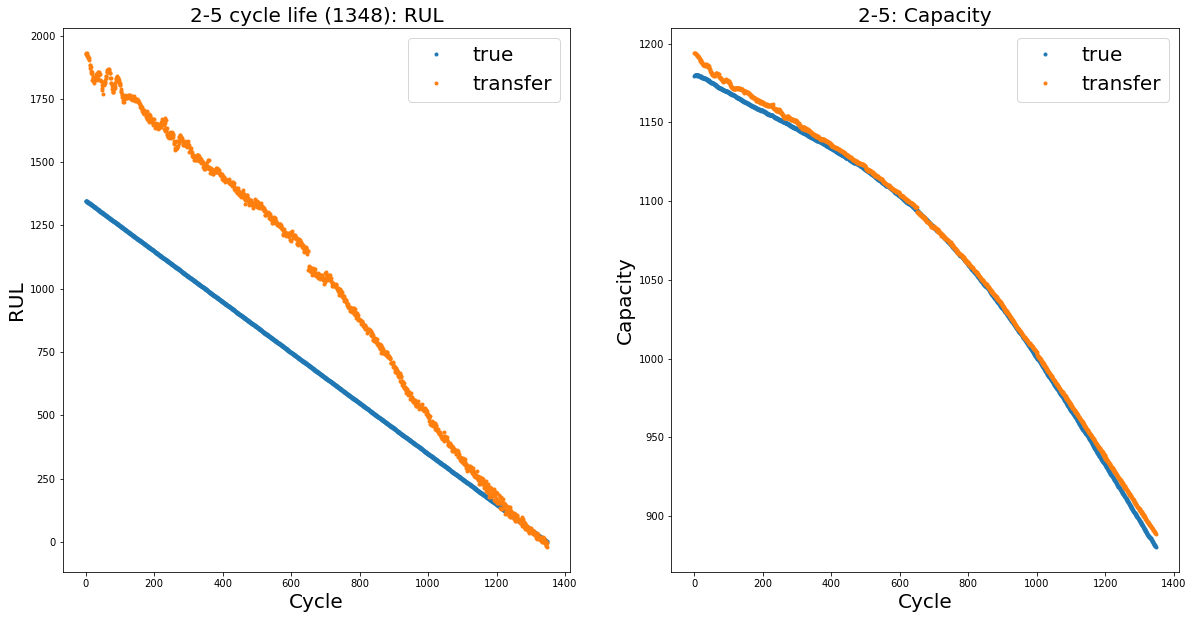

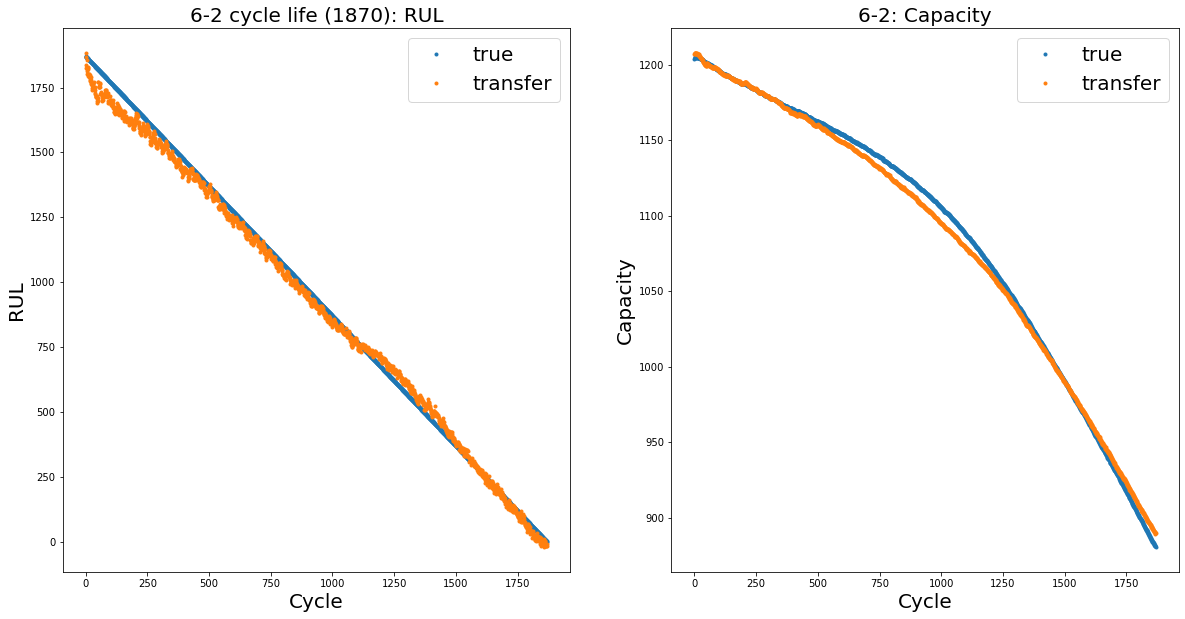

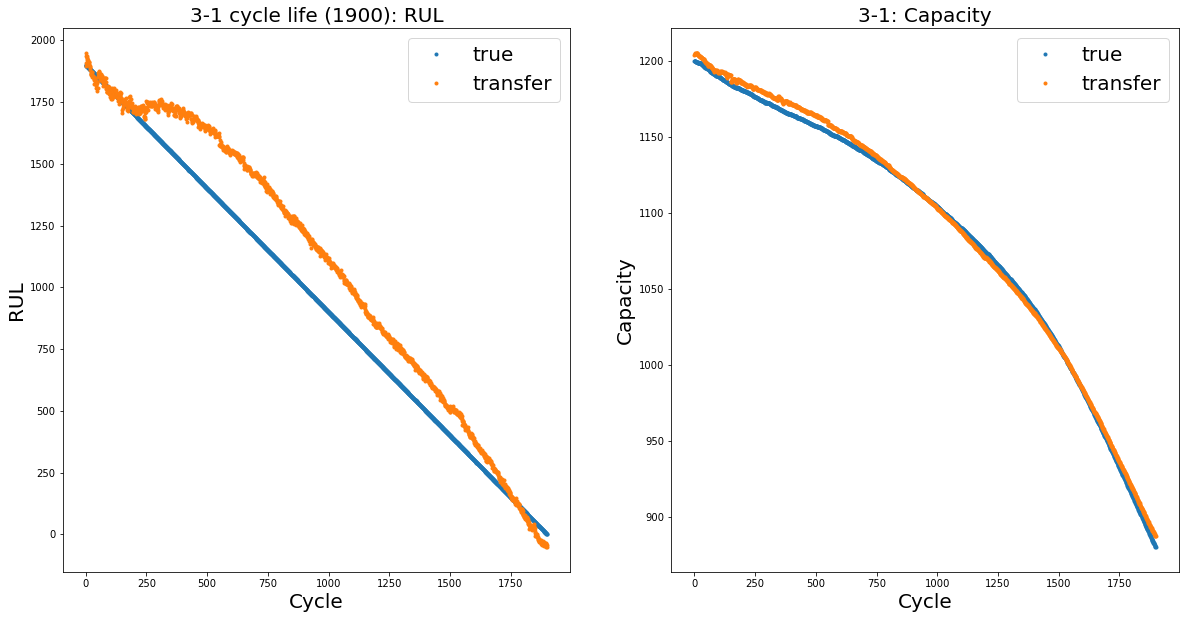

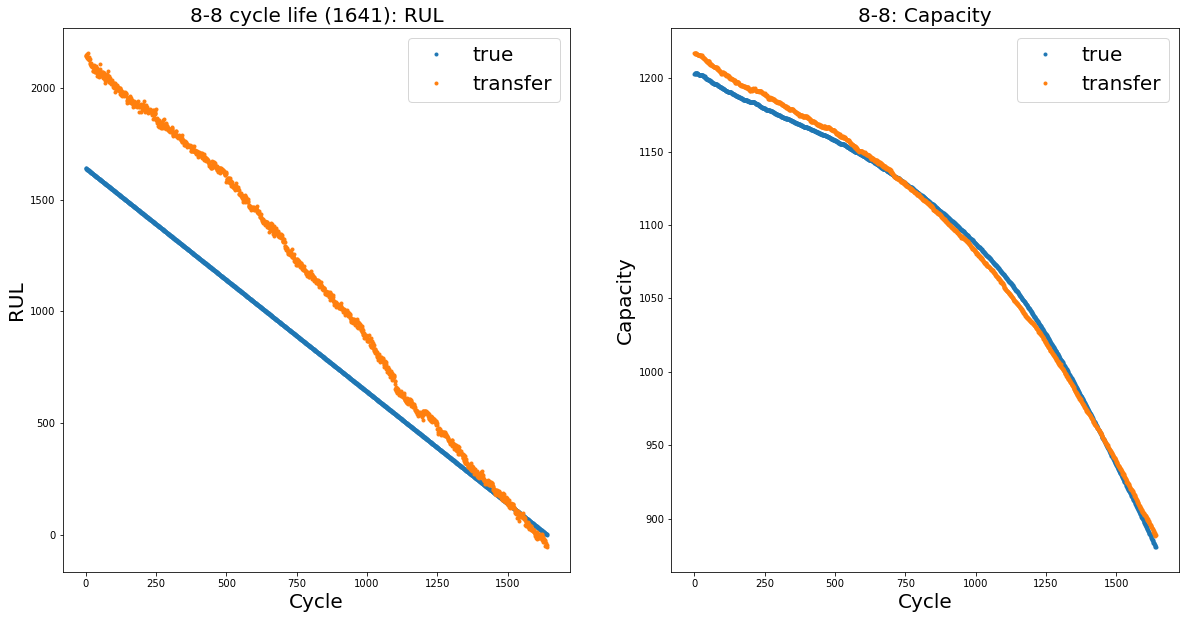

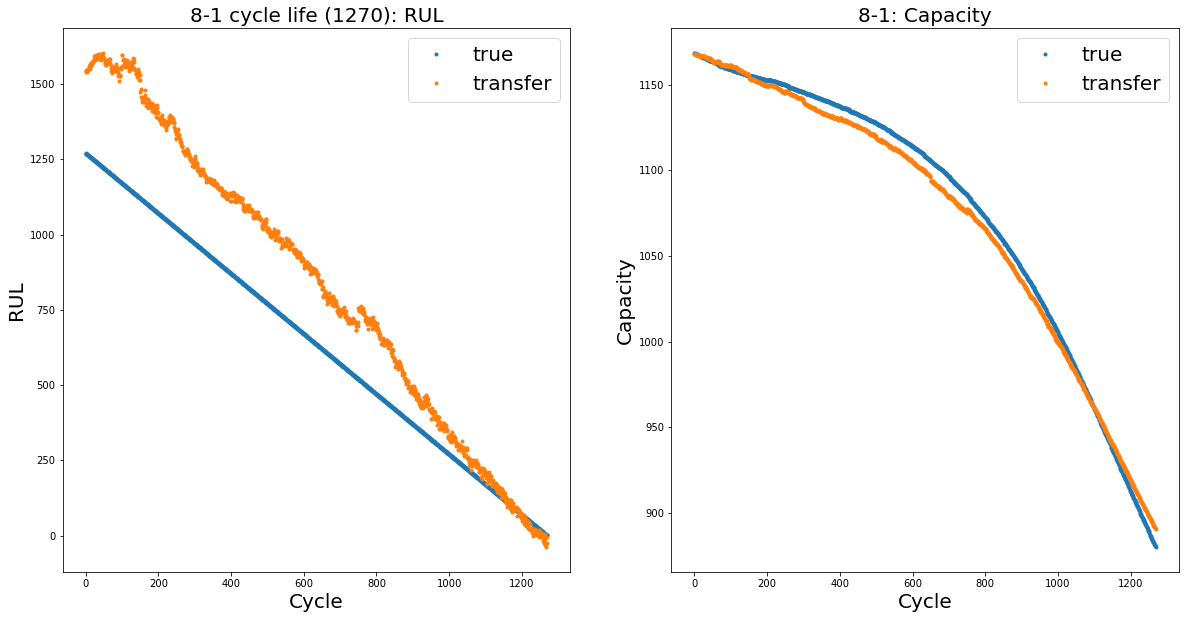

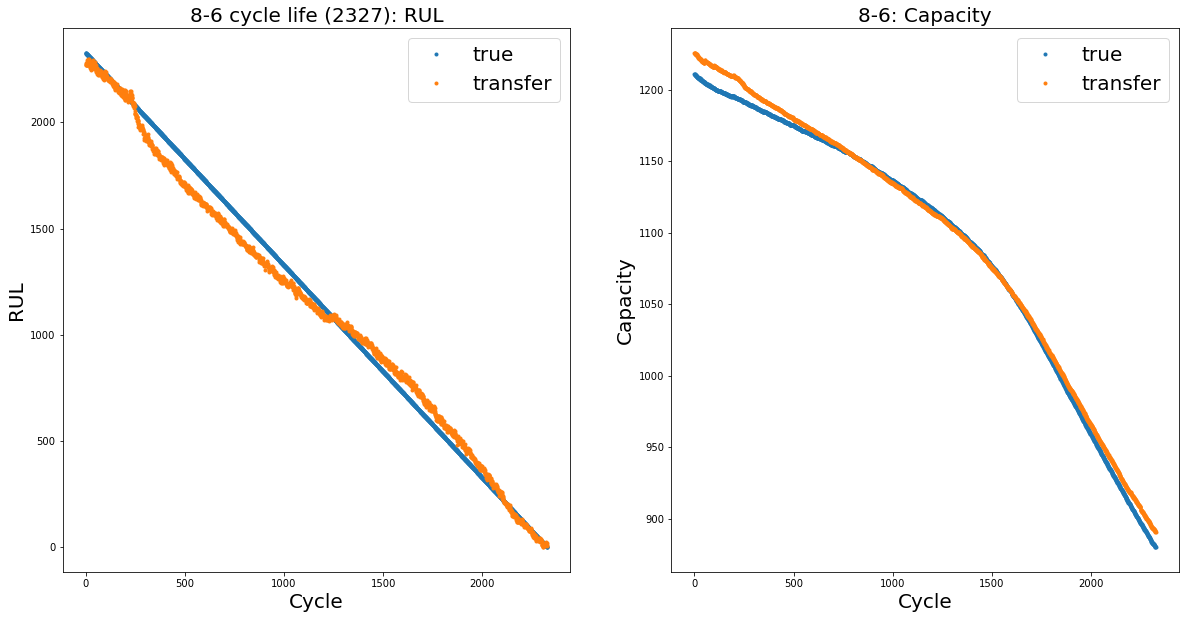

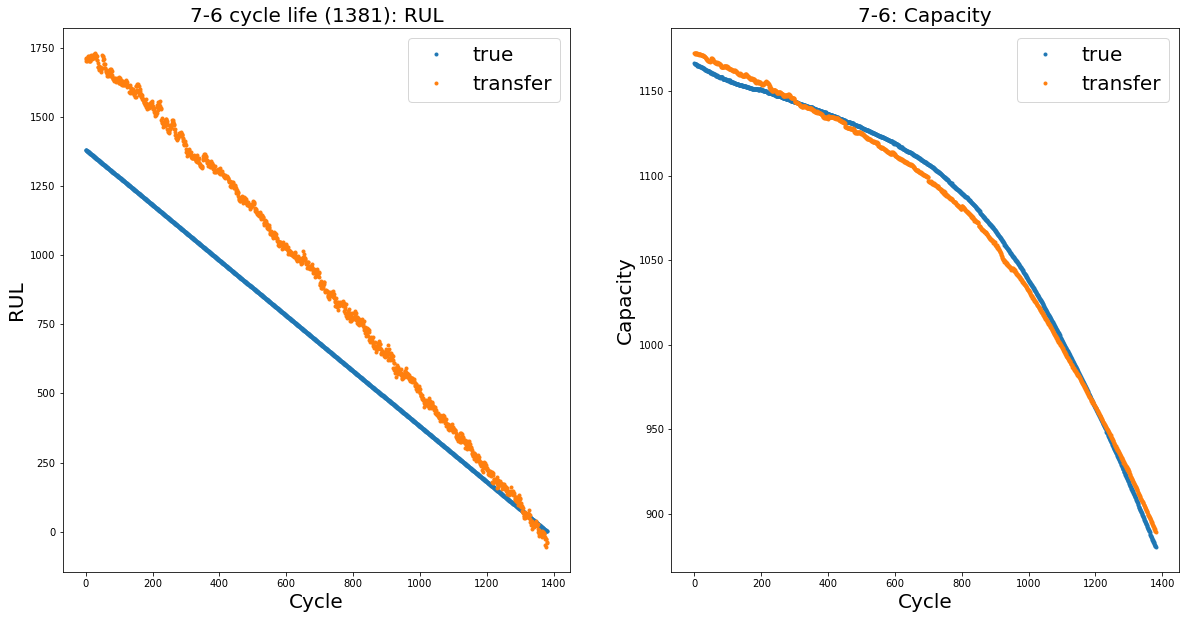

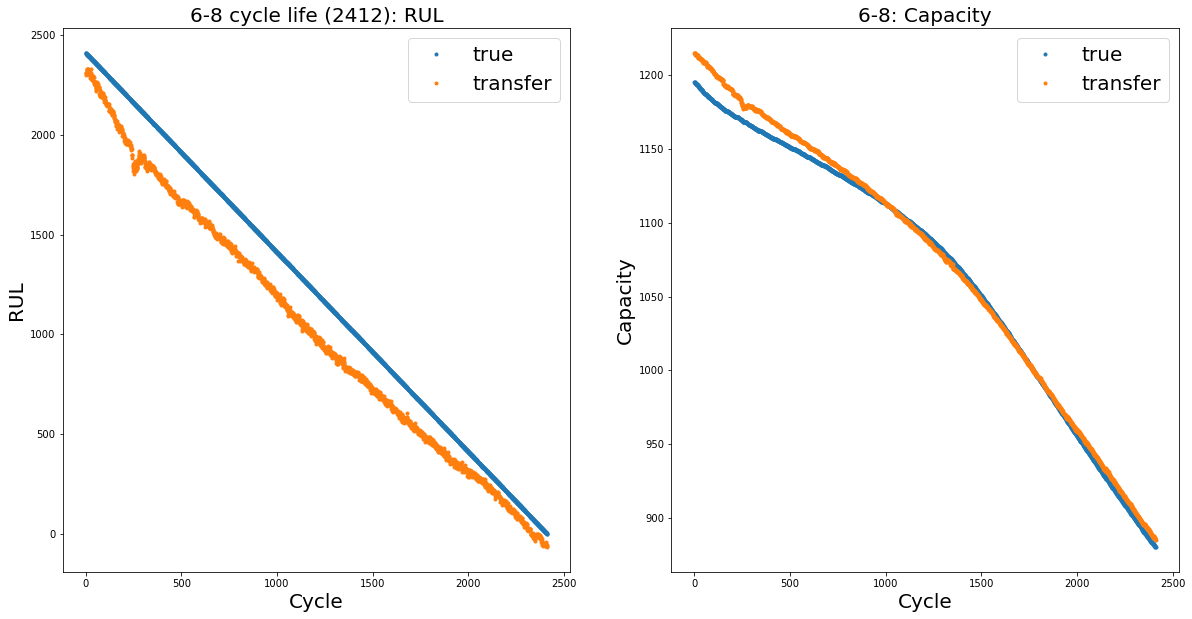

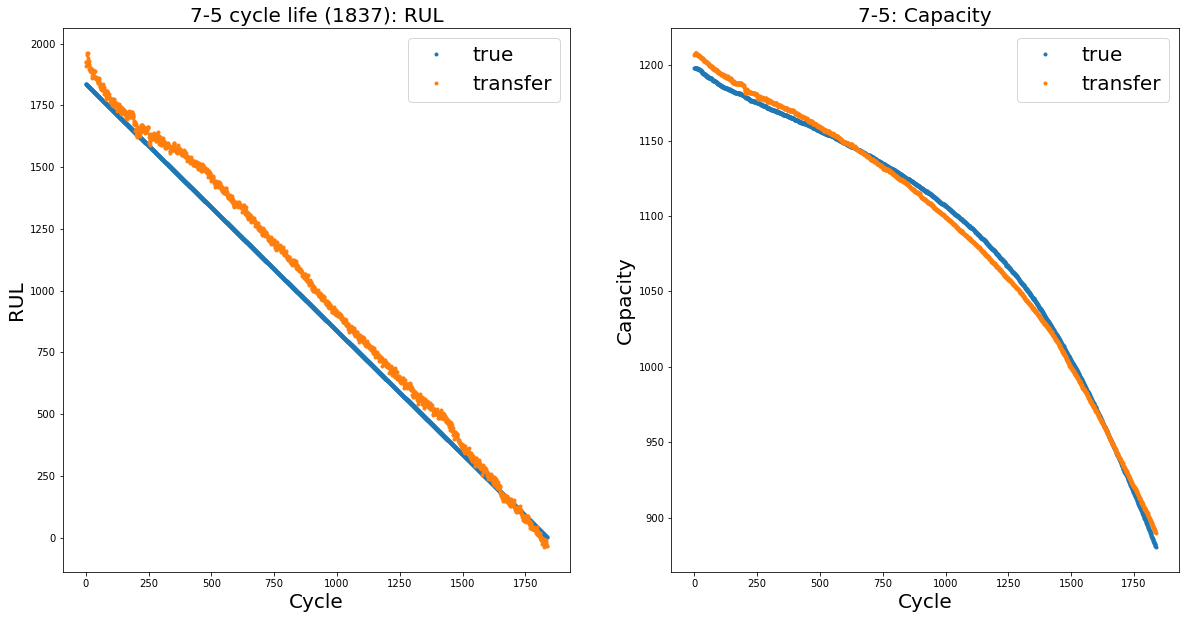

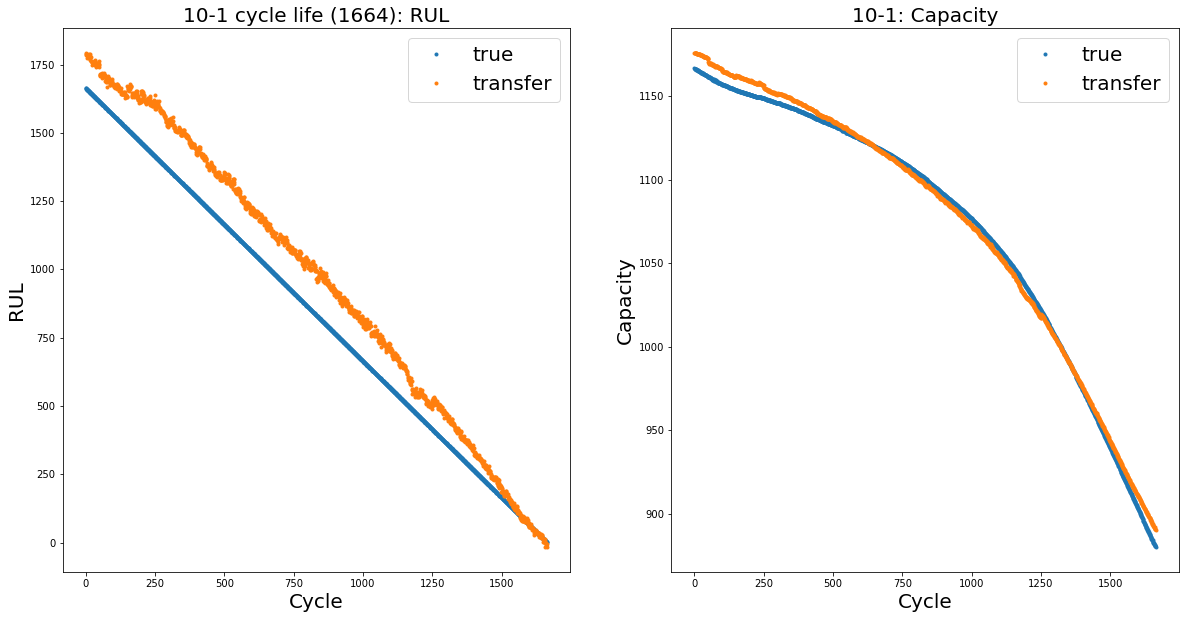

In [11]:
res_dict = {}

for name in new_test[:]:

    stride = 1
    test_fea, test_lbl = [], []
    tmp_fea, tmp_lbl = all_loader[name]['fea'],all_loader[name]['lbl']
    test_fea.append(tmp_fea[::stride])
    test_lbl.append(tmp_lbl[::stride])
    test_fea = np.vstack(test_fea)
    test_lbl = np.vstack(test_lbl).squeeze()

    batch_size = 20 if len(test_fea)%20!=1 else 21
    rul_true, rul_pred, rul_base, SOH_TRUE, SOH_PRED, SOH_BASE = [], [], [], [], [], []
    for i in range(test_fea.shape[0] // batch_size + 1):

        test_fea_ = test_fea[i*batch_size: i*batch_size+batch_size].transpose(0,3,2,1)
        test_lbl_ = test_lbl[i*batch_size: i*batch_size+batch_size]
        testset = TensorDataset(torch.Tensor(test_fea_), torch.Tensor(test_lbl_))
        test_loader = DataLoader(testset, batch_size=batch_size,)
        if test_fea_.shape[0] == 0: continue

        model = CRNN(100,4,64,64)
        model = model.to(device)
        model.load_state_dict(torch.load(pretrain_model_path))

        _, y_pred, _, _, soh_pred = trainer.test(test_loader, model)
        rul_base.append(y_pred.cpu().detach().numpy())
        SOH_BASE.append(soh_pred.cpu().detach().numpy())

        for p in model.soh.parameters():
            p.requires_grad = False
        for p in model.rul.parameters():
            p.requires_grad = False
        for p in model.cnn.parameters():
            p.requires_grad = False

        tic = time.time()
        seed_torch(2021)

        num_epochs = 120
        model_load = False
        trainer = FineTrainer(lr = 1e-4, n_epochs = num_epochs,device = device, patience = 1000,
                      lamda = lamda, train_alpha = train_alpha, valid_alpha = valid_alpha, model_name=finetune_model_path)
        model ,train_loss, valid_loss, total_loss, added_loss = trainer.train(test_loader, test_loader, model, model_load)

        y_true, y_pred, mse_loss, soh_true, soh_pred = trainer.test(test_loader, model)
        rul_true.append(y_true.cpu().detach().numpy().reshape(-1,1))
        rul_pred.append(y_pred.cpu().detach().numpy())
        SOH_TRUE.append(soh_true.cpu().detach().numpy())
        SOH_PRED.append(soh_pred.cpu().detach().numpy())

    rul_true = np.vstack(rul_true).squeeze()
    rul_pred = np.vstack(rul_pred).squeeze()
    rul_base = np.vstack(rul_base).squeeze()
    SOH_TRUE = np.vstack(SOH_TRUE)
    SOH_PRED = np.vstack(SOH_PRED)
    SOH_BASE = np.vstack(SOH_BASE)

    fig = plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.plot(rul_true[:]*rul_factor, '.',label='true')
    plt.plot(rul_pred[:]*rul_factor, '.',label='transfer')
    plt.legend(fontsize=20)
    plt.title(f'{name} cycle life ({len(test_fea)}): RUL',fontsize=20)
    plt.xlabel('Cycle',fontsize=20)
    plt.ylabel('RUL',fontsize=20)
    plt.subplot(122)
    for seq_num in range(9,10):
        plt.plot(SOH_TRUE[:,seq_num]*cap_factor, '.',label='true')
        plt.plot(SOH_PRED[:,seq_num]*cap_factor, '.',label='transfer')
    plt.legend(fontsize=20)
    plt.title(f'{name}: Capacity',fontsize=20)
    plt.xlabel('Cycle',fontsize=20)
    plt.ylabel('Capacity',fontsize=20)
    plt.show()
    
    res_dict.update({name:{
        'rul':{
            'true':rul_true[:]*rul_factor,
            'base':rul_base[:]*rul_factor,
            'transfer':rul_pred[:]*rul_factor,
        },
        'soh':{
            'true':SOH_TRUE[:,9]*cap_factor,
            'base':SOH_BASE[:,9]*cap_factor,
            'transfer':SOH_PRED[:,9]*cap_factor,
        },
                          }
                    })
    save_obj(res_dict,'./result/res_dict')

# 5-Result visualization

In [12]:
result = load_obj('result/res_dict')

In [13]:
new_test  = ['9-6','4-5','1-2', '10-7','1-1', '6-1','6-6', '9-4','10-4','8-5', '5-3','10-6',
            '2-5','6-2','3-1','8-8', '8-1','8-6','7-6','6-8','7-5','10-1']

test_1 = ['1-1','7-5','9-4','10-1','10-4','10-7']
channel_1 = ['#1', '#50', '#65', '#70', '#73', '#76']

test_2 = ['1-2', '5-3','6-1','6-6','6-8']
channel_2 = ['#2','#34', '#39', '#44', '#45']

test_3 = ['2-5','4-5','7-6','8-1','8-8','9-6']
channel_3 = ['#12', '#28', '#51', '#54', '#61', '#67']

test_4 = ['3-1','6-2','8-5','8-6','10-6',]
channel_4 = ['#16', '#40', '#58', '#59', '#75']

Text(0.5, 0, 'Actual RUL (cycles)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


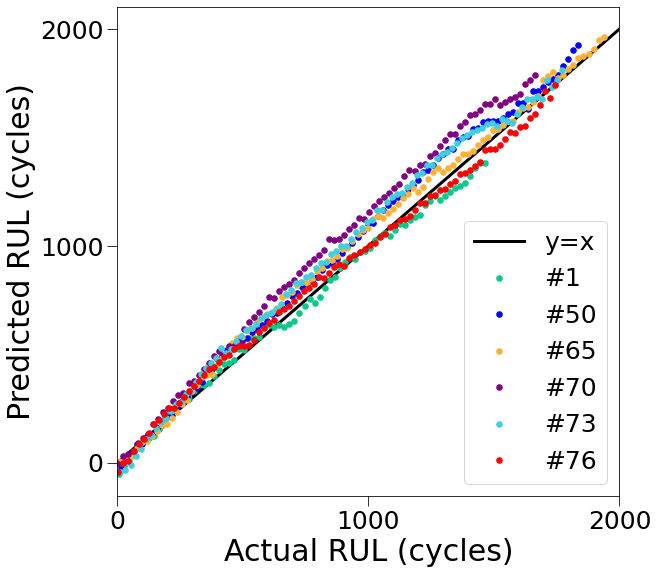

In [14]:
fig = plt.figure(figsize=(9,9))
x_lim = 2000
plt.plot(range(x_lim), range(x_lim),'-',c='k', linewidth=3,label='y=x')
cmap = plt.get_cmap('YlGnBu')
norm = plt.Normalize(vmin=0.3, vmax=1)

colors = ['#09C988','b','#FDB137','PURPLE','#40CEE3','red',]

label_names = channel_1[:]
for i, name in enumerate(test_1):
    interval = 20

    rul_true = result[name]['rul']['true'] 
    rul_base = result[name]['rul']['base']
    rul_pred = result[name]['rul']['transfer']
    
    color = [len(rul_true)/2700]*len(rul_true)
    color = color[::interval]

    plt.plot(rul_true[::interval], rul_pred[::interval], '.',markersize=11,label=label_names[i], c=colors[i])
plt.legend(fontsize=25,loc="lower right")
x_major_locator=MultipleLocator(400)
y_major_locator=MultipleLocator(400)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim((0,x_lim))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(length=10)
plt.xticks([0,1000,2000],size=25)
plt.yticks([0,1000,2000],size=25)

plt.ylabel('Predicted RUL (cycles)',fontsize=30,family='Avenir')
plt.xlabel('Actual RUL (cycles)',fontsize=30,family='Avenir')
# plt.savefig(f'Figure/fig3/rul_1.png',dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'Density')

<Figure size 648x216 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Avenir'] not found. Falling back to DejaVu Sans.


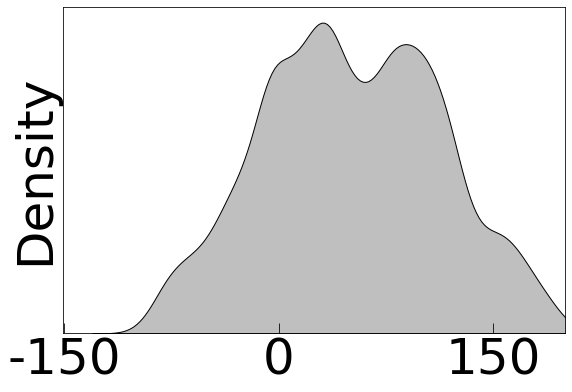

In [15]:
fig = plt.figure(figsize=(9,3))
cmap = plt.get_cmap('YlGnBu')
norm = plt.Normalize(vmin=0.3, vmax=1)
error_list = []

colors = ['k','mediumpurple','red','chocolate','limegreen','steelblue',]
label_names = ['#1', '#50','#65','#70', '#73', '#76' ]

for i, name in enumerate(test_1):
    interval = 1

    rul_true = result[name]['rul']['true'] 
    rul_pred = result[name]['rul']['transfer']
    tmp = rul_pred[::interval] - rul_true[::interval]
    error_list.append(tmp.reshape(-1,1))
    
error_array = np.vstack(error_list)

fig = plt.figure(figsize=(9,6))
sns.kdeplot(error_array.squeeze(),shade=True,color='k')
plt.xticks([-150, 0, 150],size=50)
plt.yticks([],size=50)
plt.xlim(-151,200)
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tick_params(length=10)
plt.ylabel('Density',fontsize=50,family='Avenir')
# plt.savefig(f'Figure/fig3/drul_1',dpi=1200,bbox_inches='tight')

In [21]:
new_test = test_1 + test_2 + test_3 + test_4
test_channel = channel_1 + channel_2 + channel_3 + channel_4
test_nm_ch = set(zip(test_channel,new_test))

sort_new_test = sorted(test_nm_ch, key = lambda x: int(x[0][1:]))
test_name = [i[0] for i in sort_new_test]
test_channel = [i[1] for i in sort_new_test]
cols = ['rmse_before','rmse_after',
       'r2_before','r2_after',
       'mae_before','mae_after',]

table_wx = pd.DataFrame(index=[test_name,test_channel],columns=cols)
table_wx.loc['All',:] = 0

In [22]:
stride = 1
rmse_before_list, r2_before_list, mae_before_list = [], [], []
rmse_after_list, r2_after_list, mae_after_list = [], [], []


for (code, name) in sort_new_test[:]:
    A = load_obj(f'./data/our_data/{name}')[name]
    end = A['rul'][1]
    
    A_rul = A['rul']
    A_life = A['rul'][1]
    rul_true = result[name]['rul']['true']
    rul_base = result[name]['rul']['base']
    rul_pred = result[name]['rul']['transfer']
    start = end - len(rul_true)
#     print(name, A_life, rul_true[0])
    
    rmse_before = np.sqrt(mean_squared_error(rul_true,rul_base))
    rmse_after = np.sqrt(mean_squared_error(rul_true,rul_pred))
#     print('rmse:','%.3g'%rmse_before,'%.3g'%rmse_after)
    table_wx.loc[(code, name),['rmse_before','rmse_after']] = ['%.3g'%rmse_before, '%.3g'%rmse_after]
    
    r2_before = r2_score(rul_true,rul_base)
    r2_after = r2_score(rul_true,rul_pred)
#     print('r2:','%.3g'%r2_before, '%.3g'%r2_after)
    table_wx.loc[(code, name),['r2_before','r2_after']] = ['%.3g'%r2_before, '%.3g'%r2_after]
    
    mae_before = mean_absolute_error(rul_true,rul_base) / A_life * 100
    mae_after = mean_absolute_error(rul_true, rul_pred) / A_life * 100
#     print('mae/life:','%.3g'%mae_before, '%.3g'%mae_after)
    table_wx.loc[(code, name),['mae_before','mae_after']] = ['%.3g'%mae_before, '%.3g'%mae_after]
    
#     print('')
    
    rmse_before_list.append(rmse_before)
    rmse_after_list.append(rmse_after)
    
    r2_before_list.append(r2_before)
    r2_after_list.append(r2_after)
    
    mae_before_list.append(mae_before)
    mae_after_list.append(mae_after)

table_wx.loc['All',['rmse_before','rmse_after']] = [
                                                                 '%.3g'%np.mean(rmse_before_list), 
                                                                 '%.3g'%np.mean(rmse_after_list)]
table_wx.loc['All',['r2_before','r2_after']] = [
                                                           '%.3g'%np.mean(r2_before_list), 
                                                           '%.3g'%np.mean(r2_after_list)]   
table_wx.loc['All',['mae_before','mae_after']] = [
                                                              '%.3g'%np.mean(mae_before_list), 
                                                              '%.3g'%np.mean(mae_after_list)]

In [23]:
table_wx

,,rmse_before,rmse_after,r2_before,r2_after,mae_before,mae_after
#1,1-1,74.8,40.6,0.969,0.991,3.98,2.13
#2,1-2,207,220,0.926,0.916,6.73,6.93
#12,2-5,457,384,-0.379,0.026,29.4,23.9
#16,3-1,155,164,0.921,0.91,6.89,7.29
#28,4-5,357,338,0.34,0.409,19.2,18.6
#34,5-3,184,192,0.942,0.937,5.62,5.78
#39,6-1,153,92.4,0.886,0.959,7.14,4.82
#40,6-2,70.5,37.4,0.983,0.995,2.97,1.61
#44,6-6,408,405,0.661,0.666,14,14.3
#45,6-8,177,188,0.936,0.927,6.47,7.23
